# Surving in Shipwreck

# Context

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

Our dataset is synthetic, but based on a real dataset ([the actual Titanic data](https://www.kaggle.com/c/titanic/data)) and generated using a CTGAN. The statistical properties of this dataset are very similar to the original Titanic dataset.
 
We'll explore passenger data (ie age, gender, socio-economic class, etc) to find dependencies of it and survival.

# Data Quality Assessment

In [1]:
import pandas as pd

pass_data = pd.read_csv("Datasets/titanic_train.csv", index_col="PassengerId")
pass_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


### Data Dictionary

| Variable | Definition | Key |
| :------- | :---------- | :--- |
| Survived | Survival | 0 = No, 1 = Yes |
| Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Name | Passenger name | |
| Sex | Sex | male/female |
| Age | Age in years | |
| SibSp | # of siblings / spouses aboard the Titanic | |
| Parch | # of parents / children aboard the Titanic | |
| Ticket | Ticket number | |
| Fare | Passenger fare| |
| Cabin | Cabin number | |
| Embarked| Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

**ticket** column doesn't have meaningfull information for us and we'll drop it.

In [2]:
pass_data.drop(columns=["Ticket"], inplace=True)

We'll make all the capitalization in columns' names lowercase to standartize them:

In [3]:
pass_data.columns = list(map(str.lower, pass_data.columns.to_list()))
pass_data.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'cabin', 'embarked'],
      dtype='object')

## Missing Values

In [4]:
pass_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   survived  100000 non-null  int64  
 1   pclass    100000 non-null  int64  
 2   name      100000 non-null  object 
 3   sex       100000 non-null  object 
 4   age       96708 non-null   float64
 5   sibsp     100000 non-null  int64  
 6   parch     100000 non-null  int64  
 7   fare      99866 non-null   float64
 8   cabin     32134 non-null   object 
 9   embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 8.4+ MB


Our passenger data has 100.000 samples and 10 variables.
Some columns have null-values. **cabin** column has about 68% of null-values, so we know cabins only of about 32% of
passengers. We won't drop passengers witn null-value cabin so far not to loose to many data.
**age**, **fare**, **embarked** columns have about 0.2-4.4% of null-values. Let's assess whether its missing is random or systematic.

In [5]:
pass_data[pass_data["age"].isna()]

,survived,pclass,name,sex,age,sibsp,parch,fare,cabin,embarked
PassengerId,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,13.35,NaN,S
34,1,2,"Mcmullen, Delores",female,NaN,0,0,33.66,NaN,C
35,0,3,"Hall, Booker",male,NaN,0,0,5.77,NaN,C
36,1,1,"Crowder, Nicole",female,NaN,0,0,60.02,C19277,Q
...,...,...,...,...,...,...,...,...,...,...
99772,0,1,"Hash, William",male,NaN,0,2,107.30,B21753,C
99876,1,3,"Maresco, Michael",male,NaN,0,0,22.64,NaN,C
99971,0,3,"Teague, Robert",male,NaN,0,0,7.78,NaN,S


There is no pattern of missing age and there are 3000+ samples with missing age. Let's fill null ages with mean age.

In [6]:
pass_data["age"].fillna(pass_data["age"].mean(), inplace=True)

In [7]:
pass_data[pass_data["fare"].isna()]

,survived,pclass,name,sex,age,sibsp,parch,fare,cabin,embarked
PassengerId,,,,,,,,,,
39,1,2,"Cultice, May",female,61.0,0,0,NaN,NaN,S
1404,1,1,"Kerr, Maryann",female,55.0,0,0,NaN,C5721,C
1909,1,2,"Thomas, Jennifer",female,22.0,0,0,NaN,NaN,Q
1999,0,3,"Flatley, Trena",female,3.0,1,2,NaN,NaN,S
3885,1,1,"Harding, Lillian",female,48.0,1,2,NaN,B7243,C
...,...,...,...,...,...,...,...,...,...,...
92227,1,3,"Ramsay, Miriam",female,28.0,0,0,NaN,NaN,S
93617,1,2,"Hernandez, Tina",female,51.0,0,0,NaN,NaN,Q
93908,0,2,"Cauthen, Judith",female,34.0,0,0,NaN,D16881,C


There is no pattern of missing fare and only 134 rows with null fare. Let's drop them.

In [8]:
pass_data.dropna(subset=["fare"], inplace=True)

In [9]:
pass_data[pass_data["embarked"].isna()]

,survived,pclass,name,sex,age,sibsp,parch,fare,cabin,embarked
PassengerId,,,,,,,,,,
122,0,2,"Broadway, Donald",male,65.0,0,0,23.80,NaN,NaN
266,0,3,"Rodriguez, Richard",male,26.0,0,0,7.02,NaN,NaN
489,0,1,"Dahms, Ashley",female,34.0,0,0,28.63,NaN,NaN
1017,1,1,"Palmer, Wanda",female,53.0,0,0,28.10,D7194,NaN
2005,1,1,"Savage, Maria",female,46.0,0,0,30.05,C11842,NaN
...,...,...,...,...,...,...,...,...,...,...
98228,0,3,"Kunz, Marc",male,19.0,0,0,27.97,NaN,NaN
98577,1,3,"Moncivais, Kay",female,44.0,0,1,25.46,NaN,NaN
98873,0,1,"Byers, Karen",female,47.0,2,1,28.88,A14964,NaN


There is no pattern of missing embarked. Let's keep it as is for now.

In [10]:
pass_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99866 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  99866 non-null  int64  
 1   pclass    99866 non-null  int64  
 2   name      99866 non-null  object 
 3   sex       99866 non-null  object 
 4   age       99866 non-null  float64
 5   sibsp     99866 non-null  int64  
 6   parch     99866 non-null  int64  
 7   fare      99866 non-null  float64
 8   cabin     32092 non-null  object 
 9   embarked  99617 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 8.4+ MB


## Explore duplicates

In [11]:
pass_data.duplicated().sum()

0

In [12]:
pass_data.duplicated(subset=["survived", "pclass", "name", "sex", "age", "sibsp", "parch", "cabin", "embarked"]).sum()

44

There are no full duplicates, but 31 duplicates that differ only by ticket number and fair with unknown cabin. It's very likely that they are the same people and we'll drop them.

In [13]:
pass_data = pass_data.drop_duplicates(subset=["survived", "pclass", "name", "sex", "age", "sibsp", "parch", "cabin", "embarked"])
pass_data.shape

(99822, 10)

## Values Assessment

Now let's assess data by columns to check for suspicious values:

In [14]:
pass_data.survived.value_counts()

0    57112
1    42710
Name: survived, dtype: int64

In [15]:
pass_data.pclass.value_counts()

3    40910
1    30275
2    28637
Name: pclass, dtype: int64

In [16]:
pass_data.name.value_counts()

Johnson, John      29
Smith, James       23
Smith, John        23
Smith, Michael     20
Smith, William     19
                   ..
Holbach, Gary       1
Hoover, Isabel      1
Harrison, Molly     1
Murphy, Louise      1
Enciso, Tyler       1
Name: name, Length: 92030, dtype: int64

In [17]:
pass_data.age.value_counts()

38.355472    3285
25.000000    2344
23.000000    2339
26.000000    2314
24.000000    2293
             ... 
74.500000       1
13.500000       1
78.500000       1
87.000000       1
80.500000       1
Name: age, Length: 174, dtype: int64

In [18]:
pass_data.sibsp.value_counts()

0    73165
1    19727
2     3702
3     1633
4     1167
8      296
5      132
Name: sibsp, dtype: int64

In [19]:
pass_data.parch.value_counts()

0    73402
1    12978
2    11216
3      981
4      446
5      331
9      264
6      204
Name: parch, dtype: int64

In [20]:
pass_data.fare.value_counts()

9.85      87
9.27      87
9.79      86
9.20      85
9.45      83
          ..
297.17     1
191.64     1
39.50      1
214.92     1
4.06       1
Name: fare, Length: 15935, dtype: int64

In [21]:
pass_data.cabin.value_counts()

C19828    6
C14534    5
A9127     5
B11110    5
C19623    5
         ..
C7208     1
A5788     1
C5607     1
D14672    1
D17243    1
Name: cabin, Length: 26968, dtype: int64

In [22]:
pass_data.embarked.value_counts()

S    72003
C    22154
Q     5416
Name: embarked, dtype: int64

Data has no popular default values and notable suspicious values except of many identical passenger names.

It should be interesting to explore a deck and a board (left or right) correlation with survival. The first letter in **cabin** is the deck and the last number shows the board - left if odd and right otherwise. Let's create variables for deck and board.

In [23]:
pass_data = pass_data.copy()
pass_data.loc[:, "deck"] = pass_data.cabin.str[0]
pass_data.loc[:, "board"] = pass_data.cabin.map(lambda x: "left" if int(x[-1]) % 2 == 1 else "right", 
                                            na_action="ignore") 
pass_data.head(20)

,survived,pclass,name,sex,age,sibsp,parch,fare,cabin,embarked,deck,board
PassengerId,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,38.355472,2,0,27.14,C12239,S,C,left
1,0,3,"Bryan, Drew",male,38.355472,0,0,13.35,NaN,S,NaN,NaN
2,0,3,"Owens, Kenneth",male,0.330000,1,2,71.29,NaN,S,NaN,NaN
3,0,3,"Kramer, James",male,19.000000,0,0,13.04,NaN,S,NaN,NaN
4,1,3,"Bond, Michael",male,25.000000,0,0,7.76,NaN,S,NaN,NaN
5,0,2,"Sassano, Jonathan",male,35.000000,0,0,6.71,NaN,S,NaN,NaN
6,0,3,"Conway, Jose",male,7.000000,0,0,9.77,NaN,S,NaN,NaN
7,1,3,"Werner, Linda",female,6.000000,1,2,31.50,NaN,S,NaN,NaN
8,0,1,"Wardlaw, Michael",male,27.000000,2,1,73.02,A7253,S,A,left


For convinience let's convert **pclass** column to categorical and add **survived_cat** column:

In [24]:
pass_data.loc[:, "survived_cat"] = pass_data.survived.map({0: "Died", 1: "Survived"})
pass_data.survived_cat = pd.Categorical(pass_data.survived_cat, categories=["Survived", "Died"], ordered=True)
pass_data.pclass = pass_data.pclass.astype('category')
print(pass_data.survived_cat.value_counts())
print(pass_data.pclass.value_counts())

Died        57112
Survived    42710
Name: survived_cat, dtype: int64
3    40910
1    30275
2    28637
Name: pclass, dtype: int64


# Data exploration

## Variables Distributions

In [25]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette('Set2')
matplotlib.rcParams['font.size'] = 12

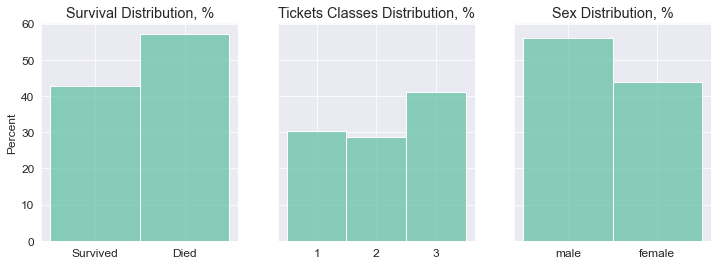

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)
sns.histplot(data=pass_data, x="survived_cat", stat="percent", ax=ax[0])
ax[0].set(xlabel='')
ax[0].title.set_text("Survival Distribution, %")

sns.histplot(data=pass_data, x="pclass", stat="percent", ax=ax[1])
ax[1].set(xlabel='')
ax[1].title.set_text("Tickets Classes Distribution, %")

sns.histplot(data=pass_data, x="sex", stat="percent", ax=ax[2])
ax[2].set(xlabel='')
ax[2].title.set_text("Sex Distribution, %")

We can see, that there was about 16% more passengers who died, than who survived, and there was about 14% more men than women on the sheep. There was more passengers of 3rd class, but not significantly.

In [27]:
pass_data["age"].describe()

count    99822.000000
mean        38.358286
std         18.011435
min          0.080000
25%         25.000000
50%         38.355472
75%         53.000000
max         87.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Passengers Ages Distribution')

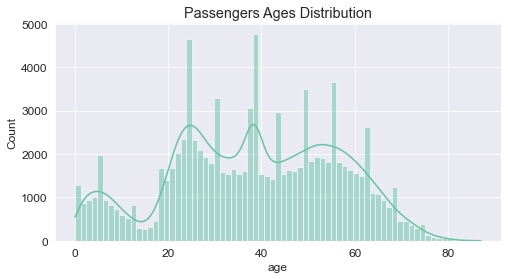

In [28]:
plt.figure(figsize=(8, 4))
sns.histplot(data=pass_data, x="age", kde=True)
plt.title("Passengers Ages Distribution")

Text(0.5, 1.0, 'Passengers Ages Distribution')

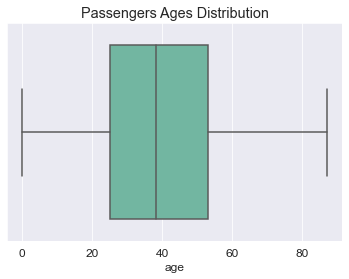

In [29]:
sns.boxplot(data=pass_data, x="age")
plt.title("Passengers Ages Distribution")

Mean passengers age was 38, half of passengers were between 25 and 53 years old. 
Let's explore age groups:

Text(0.5, 1.0, 'Passengers Ages Distribution')

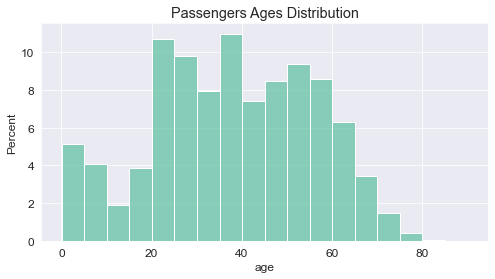

In [30]:
plt.figure(figsize=(8, 4))
sns.histplot(data=pass_data, x="age", binwidth=5, stat="percent")
plt.title("Passengers Ages Distribution")

Now we can observe that there are quite a lot of children in the dataset: almost 10% of passengers where children under 10 years and more than half of them were under 5 years old. And less then 2% passengers where 10-15 years old.

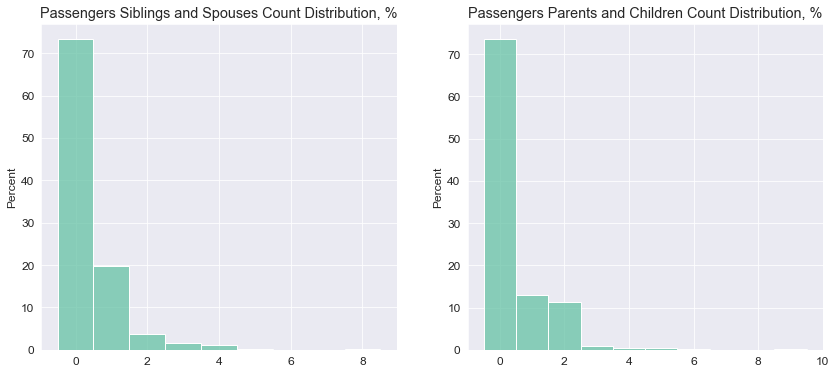

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.histplot(data=pass_data, x="sibsp", stat="percent", discrete=True, ax=ax[0])
ax[0].set(xlabel='')
ax[0].title.set_text("Passengers Siblings and Spouses Count Distribution, %")

sns.histplot(data=pass_data, x="parch", stat="percent", discrete=True, ax=ax[1])
ax[1].set(xlabel='')
ax[1].title.set_text("Passengers Parents and Children Count Distribution, %")

Most of passenger travelled alone - more thann 70% of them didn't have siblings, spouses, children and parents on the board. 20% had one spouse or sibling, about 13% had one child or parent, about 12% had two children or parents (or one child and one parent together).

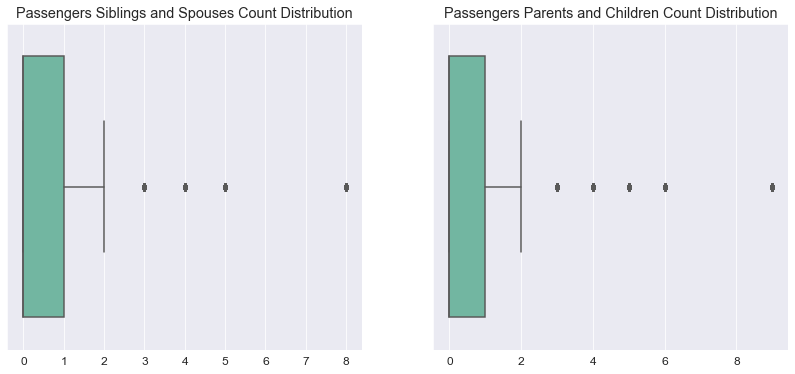

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.boxplot(data=pass_data, x="sibsp", ax=ax[0])
ax[0].set(xlabel='')
ax[0].title.set_text("Passengers Siblings and Spouses Count Distribution")

sns.boxplot(data=pass_data, x="parch", ax=ax[1])
ax[1].set(xlabel='')
ax[1].title.set_text("Passengers Parents and Children Count Distribution")

Both **sibsp** and **parch** have outliers.

Text(0.5, 1.0, 'Ticket Fares Distribution')

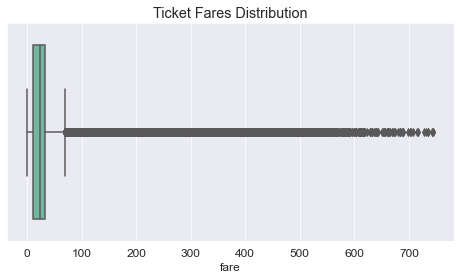

In [33]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=pass_data, x="fare")
plt.title("Ticket Fares Distribution")

In [34]:
pass_data["fare"].describe()

count    99822.000000
mean        43.943254
std         69.600849
min          0.680000
25%         10.040000
50%         24.470000
75%         33.510000
max        744.660000
Name: fare, dtype: float64

Fare mean is about 45 pounds. Interquartile range is 10-34 pounds. The cheapes ticket was 0.68 pounds and the most expensieve - 744.66 pounds. Fare variable has a big number of outliers.

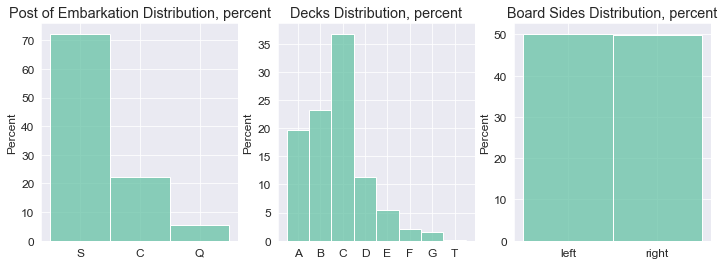

In [35]:
pass_data.deck = pd.Categorical(pass_data.deck, sorted(pass_data.deck.dropna().unique()), ordered=True)

fig, ax = plt.subplots(1, 3, figsize=(12,4))
sns.histplot(data=pass_data, x="embarked", stat="percent", ax=ax[0])
ax[0].set(xlabel='')
ax[0].title.set_text("Post of Embarkation Distribution, percent")

sns.histplot(data=pass_data, x="deck", stat="percent", ax=ax[1])
ax[1].set(xlabel='')
ax[1].title.set_text("Decks Distribution, percent")

sns.histplot(data=pass_data, x="board", stat="percent", ax=ax[2])
ax[2].set(xlabel='')
ax[2].title.set_text("Board Sides Distribution, percent")

More than 70% of passengers boarded at Southampton - the port of depature in England. About 20% added at Cherbourg, France and about 6% boarded at last port Queenstown, Nothern Ireland.

More than 35% passengers had cabins at the deck C, about 23% at the deck B, 19% at the deck A.

Passengers were distributed by the cabins of both board sides almost equally.

## Correlations

Survival and sex distributions look very similar. Let's check their correlation:

Text(0.5, 1.0, 'Surviving among men and women')

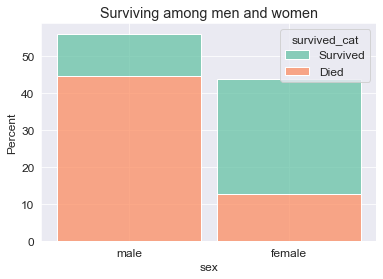

In [36]:
sns.histplot(data=pass_data, x="sex", hue="survived_cat", stat="percent", multiple="stack", shrink=.9)
plt.title("Surviving among men and women")

In [37]:
surv_men = pass_data[(pass_data["sex"] == "male") & pass_data["survived"]].shape[0]
surv_men_coef = surv_men/pass_data[pass_data["sex"] == "male"].shape[0]
print("{:.0%} of men survived.".format(surv_men_coef))
surv_women = pass_data[(pass_data["sex"] == "female") & pass_data["survived"]].shape[0]
surv_women_coef = surv_women/pass_data[pass_data["sex"] == "female"].shape[0]
print("{:.0%} of women survived.".format(surv_women_coef))

21% of men survived.
71% of women survived.


It's known that Titanics captain order was to take on lifeboats only women and children. We can see that in our dataset correlation between survival and sex is very strong and 80% men died however 71$ women survived. The order wasn't far from being executed. Let's check what about children and age dependence at all.

Text(0.5, 1.0, 'Survivng by ages distribution')

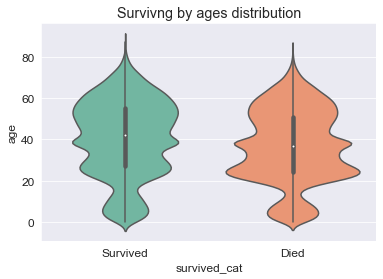

In [38]:
sns.violinplot(x="survived_cat", y="age", data=pass_data)
plt.title("Survivng by ages distribution")

There is no strong difference in shapes, but we can notice that more 20-30 years old passenger died comparing to other and that 50-60 years old passengers survived more than died. Let's look at numbers:

In [39]:
pass_data.loc[:, "age_cat"] = pd.cut(pass_data.age, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90], 
                                       labels=["<10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90"])
pass_data.head()

,survived,pclass,name,sex,age,sibsp,parch,fare,cabin,embarked,deck,board,survived_cat,age_cat
PassengerId,,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,38.355472,2,0,27.14,C12239,S,C,left,Survived,30-40
1,0,3,"Bryan, Drew",male,38.355472,0,0,13.35,NaN,S,NaN,NaN,Died,30-40
2,0,3,"Owens, Kenneth",male,0.330000,1,2,71.29,NaN,S,NaN,NaN,Died,<10
3,0,3,"Kramer, James",male,19.000000,0,0,13.04,NaN,S,NaN,NaN,Died,10-20
4,1,3,"Bond, Michael",male,25.000000,0,0,7.76,NaN,S,NaN,NaN,Survived,20-30


In [40]:
age_surv_data = pass_data.groupby("age_cat")["age"].count().reset_index().set_index("age_cat")
age_surv_data.loc[:, "survived"] = pass_data[pass_data.survived == 1].groupby("age_cat")["age"].count()
age_surv_data.rename(columns={"age": "all"}, inplace=True)
age_surv_data = age_surv_data.reset_index()
age_surv_data.loc[:, "surv_perc"] = round(100*age_surv_data["survived"] / age_surv_data["all"], 1)
age_surv_data

,age_cat,all,survived,surv_perc
0,<10,9201,3770,41.0
1,10-20,5777,2340,40.5
2,20-30,20495,7029,34.3
3,30-40,18908,7352,38.9
4,40-50,15874,7543,47.5
5,50-60,17914,8422,47.0
6,60-70,9717,5003,51.5
7,70-80,1888,1213,64.2
8,80-90,48,38,79.2


Text(0.5, 1.0, 'Survived Passengers by Age Groups')

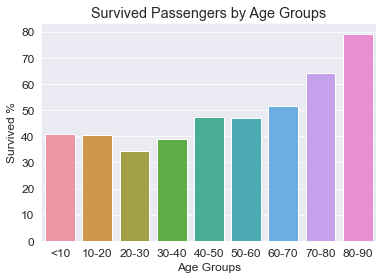

In [41]:
sns.barplot(data=age_surv_data, x="age_cat", y="surv_perc")
plt.xlabel("Age Groups")
plt.ylabel("Survived %")
plt.title("Survived Passengers by Age Groups")

So children survival was less than survival of the passengers older than 40 years. The lowest survival was in 20-30 ages group and the highest for the passenger older 60 years. Logically, young people are generally healthier, stronger and quicker and should be able to get to the lifeboat first while elderly peoply should be last. So most likely that this correlation isn't correct and could be explained with hypothesis thar elder people were reacher and had tickets in higher class with opportunity to get to the lifeboat quicker.

Let's check ticket classes:

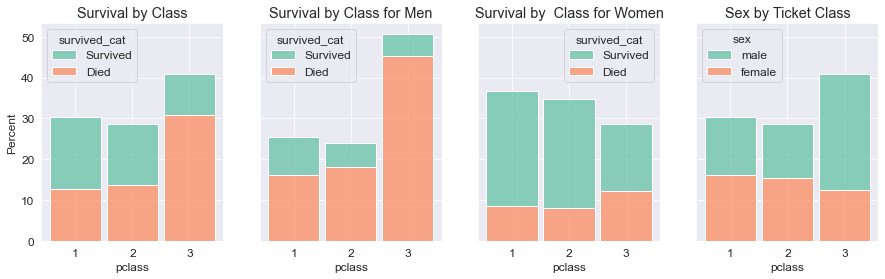

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(15,4), sharey=True)

sns.histplot(data=pass_data, x="pclass", hue="survived_cat", stat="percent", multiple="stack", shrink=.9, ax=ax[0])
ax[0].title.set_text("Survival by Class")

sns.histplot(data=pass_data[pass_data.sex == "male"], x="pclass", hue="survived_cat", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[1])
ax[1].title.set_text("Survival by Class for Men")

sns.histplot(data=pass_data[pass_data.sex == "female"], x="pclass", hue="survived_cat", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[2])
ax[2].title.set_text("Survival by  Class for Women")

sns.histplot(data=pass_data, x="pclass", hue="sex", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[3])
ax[3].title.set_text("Sex by Ticket Class")

There's a strong survival correlation with ticket class: while more than half of passengers of 1st and 2nd class survived, 3/4 of passengers of 3rd class died. Percents of died men in 3rd class is 10% more than in 2nd and 24% more than in 1st class. But it's more important that number of men in 3rd class was almost the same as in 1st and 2nd together. Women are spreaded by classes more evenly: about 29% in 3rd class, 34% in 2nd class, 37% in 1st class. About 24% of women if 1st and 2nd classes died and 41% in 3rd class. So sex and ticket class both are strong correlated with survival.

Let's check ticket classes distribution by age groups:

Text(0.5, 1.0, 'Age Group by Ticket Class')

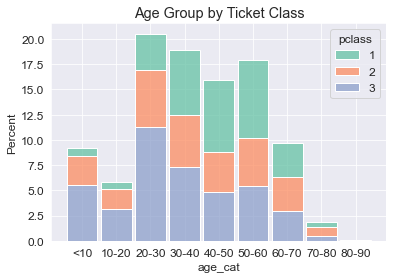

In [43]:
sns.histplot(data=pass_data, x="age_cat", hue="pclass", stat="percent", multiple="stack", shrink=.9)
plt.title("Age Group by Ticket Class")

We see that a percent of 3rd class tickets goes down while age grows up, a part of 2nd class tickets is smaller for 30-60 years old passengers than for 20-30 and 60+ ones and in the same time a part of 1st class tickets is bigger. Generally it proves the hypothesis that survival depends on ticket class, but not depends on age straightly, but ticket classes distribution depends on ages.

Text(0.5, 1.0, 'Fare Distribution by Survival')

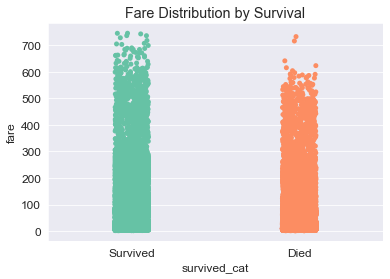

In [44]:
sns.stripplot(x="survived_cat", y="fare", data=pass_data)
plt.title("Fare Distribution by Survival")

We can infer that rather more passengers with tickets for 500-600 pounds survived than died. Most passengers with tickets for more then 600 pounds survived.

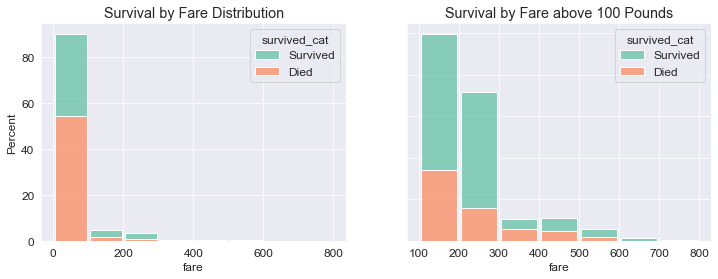

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=pass_data, x="fare", hue="survived_cat", binwidth=100, stat="percent", 
             multiple="stack", shrink=.9, ax=ax[0])
ax[0].title.set_text("Survival by Fare Distribution")

sns.histplot(data=pass_data[pass_data["fare"] > 100], x="fare", hue="survived_cat", binwidth=100, 
             stat="percent", multiple="stack", shrink=.9, ax=ax[1])
ax[1].title.set_text("Survival by Fare above 100 Pounds")
ax[1].set(ylabel='', yticklabels=[])
plt.show()

More than 85% of passengers had tickets for 0-100 pounds. About 60% of them died. Passengers with more expensive tickets mostly survived, except of passengers with tickets for 300-400 pounds. So fare is correlated with survival, but the correlation isn't strong.

Text(0.5, 1.0, 'Fare Distribution by Ticket Class')

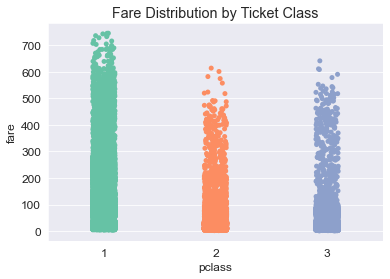

In [46]:
sns.stripplot(x="pclass", y="fare", data=pass_data)
plt.title("Fare Distribution by Ticket Class")

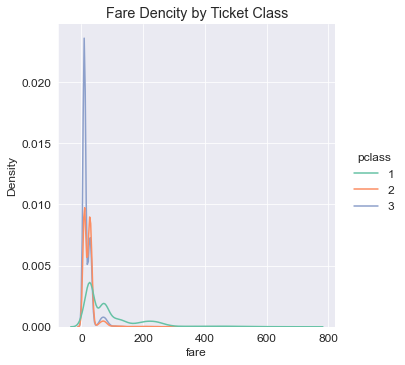

In [47]:
sns.displot(data=pass_data, x="fare", hue="pclass", kind="kde")
plt.title("Fare Dencity by Ticket Class")
plt.show()

Surprisingly, the fare range for different classes doesn't change a lot: there are very cheap tickets in all classes and some expensive tickets even in 3rd class. But fare has different distribution for different classes: the lower class is, the more number of cheap tickets there are for it and vice versa.

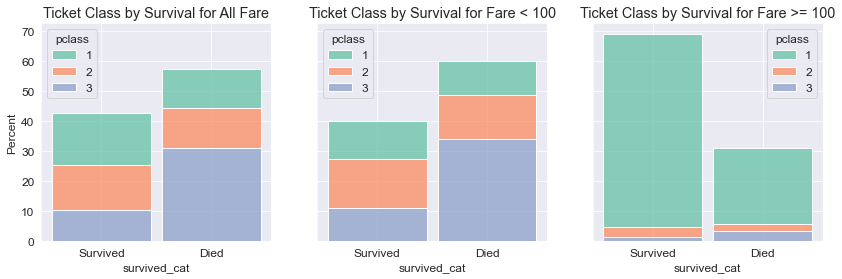

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(14,4), sharey=True)

sns.histplot(data=pass_data, x="survived_cat", hue="pclass", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[0])
ax[0].title.set_text("Ticket Class by Survival for All Fare")

sns.histplot(data=pass_data[pass_data.fare < 100], x="survived_cat", hue="pclass", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[1])
ax[1].title.set_text("Ticket Class by Survival for Fare < 100")

sns.histplot(data=pass_data[pass_data.fare >= 100], x="survived_cat", hue="pclass", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[2])
ax[2].title.set_text("Ticket Class by Survival for Fare >= 100")

The first two histograms don't different a lot. That's because more than 85% passengers had tickets for 0-100 pounds. Passengers with tickets cheaper than 50 pounds survived for several percents more rarely than in average. Almost 70% of passengers with tickets more expensive than 100 pounds survived. They consisted of 1st class passengers on more than 90%.

In [49]:
pass_data.loc[:, "is_cabin"] = "Cabin unknown"
pass_data.loc[pass_data["cabin"].notnull(), "is_cabin"] = "Cabin known"
pass_data.head(10)

,survived,pclass,name,sex,age,sibsp,parch,fare,cabin,embarked,deck,board,survived_cat,age_cat,is_cabin
PassengerId,,,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,38.355472,2,0,27.14,C12239,S,C,left,Survived,30-40,Cabin known
1,0,3,"Bryan, Drew",male,38.355472,0,0,13.35,NaN,S,NaN,NaN,Died,30-40,Cabin unknown
2,0,3,"Owens, Kenneth",male,0.330000,1,2,71.29,NaN,S,NaN,NaN,Died,<10,Cabin unknown
3,0,3,"Kramer, James",male,19.000000,0,0,13.04,NaN,S,NaN,NaN,Died,10-20,Cabin unknown
4,1,3,"Bond, Michael",male,25.000000,0,0,7.76,NaN,S,NaN,NaN,Survived,20-30,Cabin unknown
5,0,2,"Sassano, Jonathan",male,35.000000,0,0,6.71,NaN,S,NaN,NaN,Died,30-40,Cabin unknown
6,0,3,"Conway, Jose",male,7.000000,0,0,9.77,NaN,S,NaN,NaN,Died,<10,Cabin unknown
7,1,3,"Werner, Linda",female,6.000000,1,2,31.50,NaN,S,NaN,NaN,Survived,<10,Cabin unknown
8,0,1,"Wardlaw, Michael",male,27.000000,2,1,73.02,A7253,S,A,left,Died,20-30,Cabin known


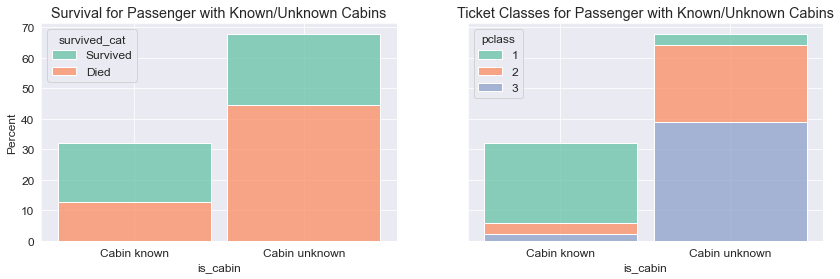

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(14,4), sharey=True)

sns.histplot(data=pass_data, x="is_cabin", hue="survived_cat", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[0])
ax[0].title.set_text("Survival for Passenger with Known/Unknown Cabins")

sns.histplot(data=pass_data, x="is_cabin", hue="pclass", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[1])
ax[1].title.set_text("Ticket Classes for Passenger with Known/Unknown Cabins")

About 2/3 of passengers with unknown cabin died. Cabins of almost all passengers with 3rd ticket class are unknown. We've discovered earlier that survival for 3rd class was rather lower - that can explain low survival for "Cabin unknown" category.

Text(0.5, 1.0, 'Known/Unnown Cabin by Ticket Class')

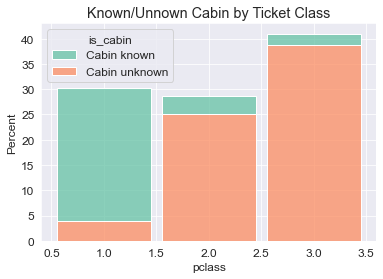

In [51]:
sns.histplot(data=pass_data, x="pclass", hue="is_cabin", stat="percent", multiple="stack", shrink=.9)
plt.title("Known/Unnown Cabin by Ticket Class")

So we know cabins for more than 80% of 1st class passengers and don't know for most 2nd and 3rd passengers.

Text(0.5, 1.0, 'Survival by Deck')

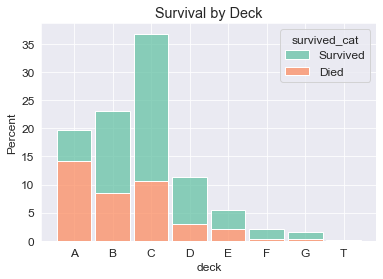

In [52]:
sns.histplot(data=pass_data, x="deck", hue="survived_cat", stat="percent", multiple="stack", shrink=.9)
plt.title("Survival by Deck")

By this histogramm we can assess survival mostly only for 1st class passengers from different decks. Survival is growing from A to G deck.

Text(0.5, 1.0, 'Survival by Board Side')

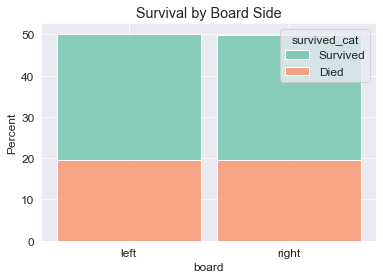

In [53]:
sns.histplot(data=pass_data, x="board", hue="survived_cat", stat="percent", multiple="stack", shrink=.9)
plt.title("Survival by Board Side")

Board side had definitely no influence on survival. Let's drop this column.

In [54]:
pass_data.drop(columns=["board"], inplace=True)

Text(0.5, 1.0, 'Survival by Embarkation Port')

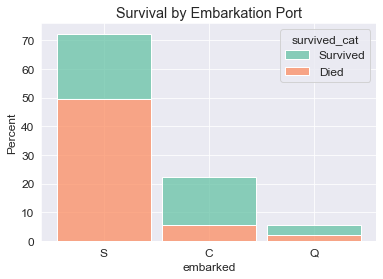

In [55]:
sns.histplot(data=pass_data, x="embarked", hue="survived_cat", stat="percent", multiple="stack", shrink=.9)
plt.title("Survival by Embarkation Port")

Text(0.5, 1.0, 'Survival by Embarkation Port')

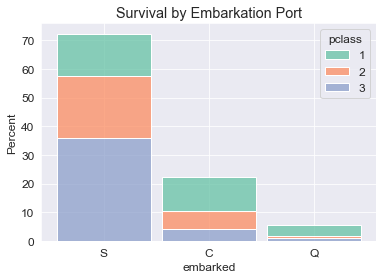

In [56]:
sns.histplot(data=pass_data, x="embarked", hue="pclass", stat="percent", multiple="stack", shrink=.9)
plt.title("Survival by Embarkation Port")

Survival is low for Southampton because mostly passengers on 3rd ticket class were boaded there and little of 1st class passengers. So there is no straight correlation between port and survival.

Text(0.5, 1.0, 'Correlations Table')

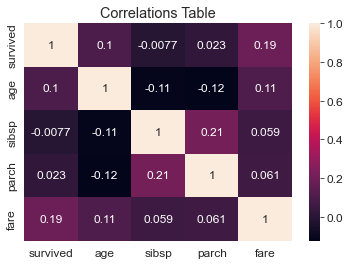

In [57]:
sns.heatmap(data=pass_data.corr(), annot=True)
plt.title("Correlations Table")

From correlations table we can prove that survival and fare are middle-correlated and survival and age are low-correlated. Parch and sibsp have very low correlation with survival.

<AxesSubplot:xlabel='survived_cat', ylabel='Percent'>

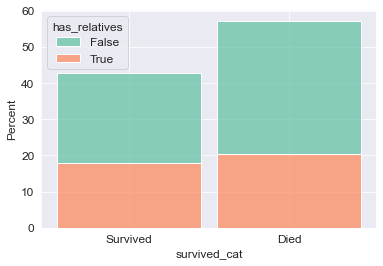

In [58]:
pass_data.loc[:, "has_relatives"] = (pass_data.parch > 0) | (pass_data.sibsp > 0)
sns.histplot(data=pass_data, x="survived_cat", hue="has_relatives", stat="percent", multiple="stack", shrink=.9)

<AxesSubplot:xlabel='pclass', ylabel='Percent'>

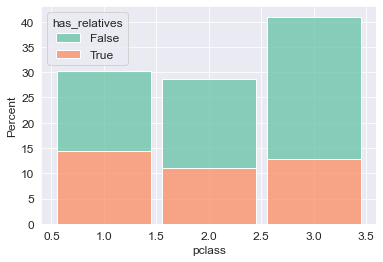

In [59]:
sns.histplot(data=pass_data, x="pclass", hue="has_relatives", stat="percent", multiple="stack", shrink=.9)

About 65% of died passengers travelled alone but more likely that because near the same pecent of 3rd class passengers travelled alone. Due to low correlation of parch and sibsp with survived we infer that isn't important relationship.

# Summary

We've discovered that the main variables that influence on survival are sex and ticket class.

In [ ]:
sns.catplot(x="sex", y="survived", hue="pclass", kind="point", data=pass_data)
plt.title("Survival by Sex and Ticket Class")
plt.show()

So by our dataset the highest probability to survive had women in 1st and 2nd class, then women in 3rd class, then men in 1st, 2nd and last 3rd class.

In [ ]:
sns.catplot(x="deck", y="survived", hue="pclass", kind="point", data=pass_data)
plt.title("Survival by Deck and Ticket Class")

Passengers of all classes had a high probabilty to survive if they had cabins on F and G deck. Passengers of 1st and 2nd class from deck B, C, D, E had a rather hight probabilty to survive too. The worst decks for surviving were A and T.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,4), sharey=True)

sns.histplot(data=pass_data[pass_data.fare < 100], x="survived_cat", hue="pclass", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[0])
ax[0].title.set_text("Ticket Class by Survival for Fare < 100")

sns.histplot(data=pass_data[pass_data.fare >= 100], x="survived_cat", hue="pclass", stat="percent", 
             multiple="stack", shrink=.9, ax=ax[1])
ax[1].title.set_text("Ticket Class by Survival for Fare >= 100")

Passengers with tickets for more than 100 pounds had almost 70% probability to survive, while passengers with cheaper tickets - only 40%.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
sns.pointplot(x="parch", y="survived", hue="sex", data=pass_data, ax=ax[0])
ax[0].title.set_text("Survival by Parents and Children Count and Sex")
sns.pointplot(x="sibsp", y="survived", hue="sex", data=pass_data, ax=ax[1])
ax[1].title.set_text("Survival by Siblings and Spouses Count and Ticket Class")

Generally women with more relatives had less probability to survive. For men there is no visible correlation.

## Conclusion

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

surv_data = pass_data[pass_data.survived == 1]

sns.histplot(data=surv_data[(surv_data.sex == "female") & (surv_data.pclass != 3)], x="fare", hue="deck", binwidth=100, stat="percent", 
             multiple="stack", shrink=.9, ax=ax[0])
ax[0].title.set_text("Fare and Decks Distribution among Survived Women")

died_data = pass_data[pass_data.survived == 0]

sns.histplot(data=died_data[(died_data.sex == "male") & (died_data.pclass == 3)], x="fare", hue="deck", binwidth=100, stat="percent", 
             multiple="stack", shrink=.9, ax=ax[1])
ax[1].title.set_text("Fare and Decks Distribution among Died Men")

So the most passengers who survived were women from 1st and 2nd class from B and C decks with no relatives or one parent or child. A fare for them didn't have a significant influence.

The most passengers who died were men from 3rd class with tickets for less than 100 pounds from C and A decks.

In [ ]:
pass_data.loc[:, "fare_cat"] = pd.cut(pass_data["fare"], bins=[0, 50, 100, 200, 300, 400, 500, 600, 800], 
                                     labels=["<50", "50-100", "100-200", "200-300", "300-400", "400-500", 
                                             "500-600", "600-800"])

pass_data_gr = pass_data.groupby(by=["sex", "pclass", "fare_cat"]).mean()["survived"].reset_index()
pass_data_piv = pass_data_gr.pivot(index=["sex", "pclass"], columns="fare_cat", values="survived")
plt.figure(figsize=(8, 6))
sns.heatmap(pass_data_piv, annot=True)

The heatmap proves the tendence that among all passengers the highest probabilty to survive had women from 1st and 2nd class and it increased for more expensive ticket owners.
Among men the highest probabilty to survive had men from 1st and 2nd with expensive tickets. All men from 3rd class had very low survival probabilty.

In [ ]:
pass_data_gr = pass_data.groupby(by=["sex", "pclass", "deck"]).mean()["survived"].reset_index()
pass_data_piv = pass_data_gr.pivot(index=["sex", "pclass"], columns="deck", values="survived")
plt.figure(figsize=(8, 6))
sns.heatmap(pass_data_piv, annot=True)

This heatmap proves that passengers from A deck had the lowest survival probabilty as well as men from 3rd class regardless of the deck. For women from 3rd class the survival probabilty grows significantly fom A to T deck (there is a little subsidence for E deck). 
For men from 1st and 2nd class and decks B-G the probabilty doesn't differ a lot. The same for women.